In [8]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram, get_region_volume 
from constants import MASS_BINS, Z_MAX
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve

In [9]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey
galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters EFEDS

In [10]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 14,           # Font size for text
    'axes.titlesize': 16,      # Font size for axes titles
    'axes.labelsize': 14,      # Font size for x and y labels
    'xtick.labelsize': 14,     # Font size for x tick labels
    'ytick.labelsize': 14,     # Font size for y tick labels
    'legend.fontsize': 14,     # Font size for legend text
    'figure.figsize': (20, 12), # Default figure size
})

In [11]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < Z_MAX) &
    # (sciencegkv_galaxies_raw['Z'] <= 0.4) &
    # (sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (sciencegkv_galaxies_raw['Z'] != 0) &
    # (sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    (sciencegkv_galaxies_raw['RAcen'] > 129.0) &
    (sciencegkv_galaxies_raw['RAcen'] < 141.0) &
    (sciencegkv_galaxies_raw['Deccen'] > -2.0) &
    (sciencegkv_galaxies_raw['Deccen'] < 3.0)  &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        # (galaxies_raw['Z'] <= 0.4) &
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < Z_MAX) &
        (galaxies_raw['RAcen'] > 129.0) &
        (galaxies_raw['RAcen'] < 141.0) &
        (galaxies_raw['Deccen'] > -2.0) &
        (galaxies_raw['Deccen'] < 3.0)  &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        ~np.isnan(clusters_raw['VDISP']) &  # mask clusters which don't have VDISP values
        (clusters_raw['ZBEST'] <= Z_MAX) &
        (clusters_raw['RA'] > 129) &
        (clusters_raw['RA'] < 141.5) &
        (clusters_raw['DEC'] > -2.05) &
        (clusters_raw['DEC'] < 3.02)
)



big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]

In [12]:
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

In [13]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['ZBEST'].byteswap().newbyteorder(),
    'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),
})



# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
})

In [ ]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)

In [7]:
matched_galaxy_dataframe.to_csv('matched_galaxy_df.csv')

NameError: name 'matched_galaxy_dataframe' is not defined

In [14]:
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [15]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner", on="uberID")

In [16]:
mass_for_richards_curve = np.logspace(5,12.25, 1000)
mass_luminosity_cutoff = get_mass_luminosity_cutoff(merged_galaxy_df, cut_off_percentage=95)
richards_curve = get_distance_from_mass(mass_for_richards_curve, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
merged_galaxy_df['within_richards_curve'] = merged_galaxy_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_for_richards_curve, row['mstar'], row['comoving_distance']), axis=1)


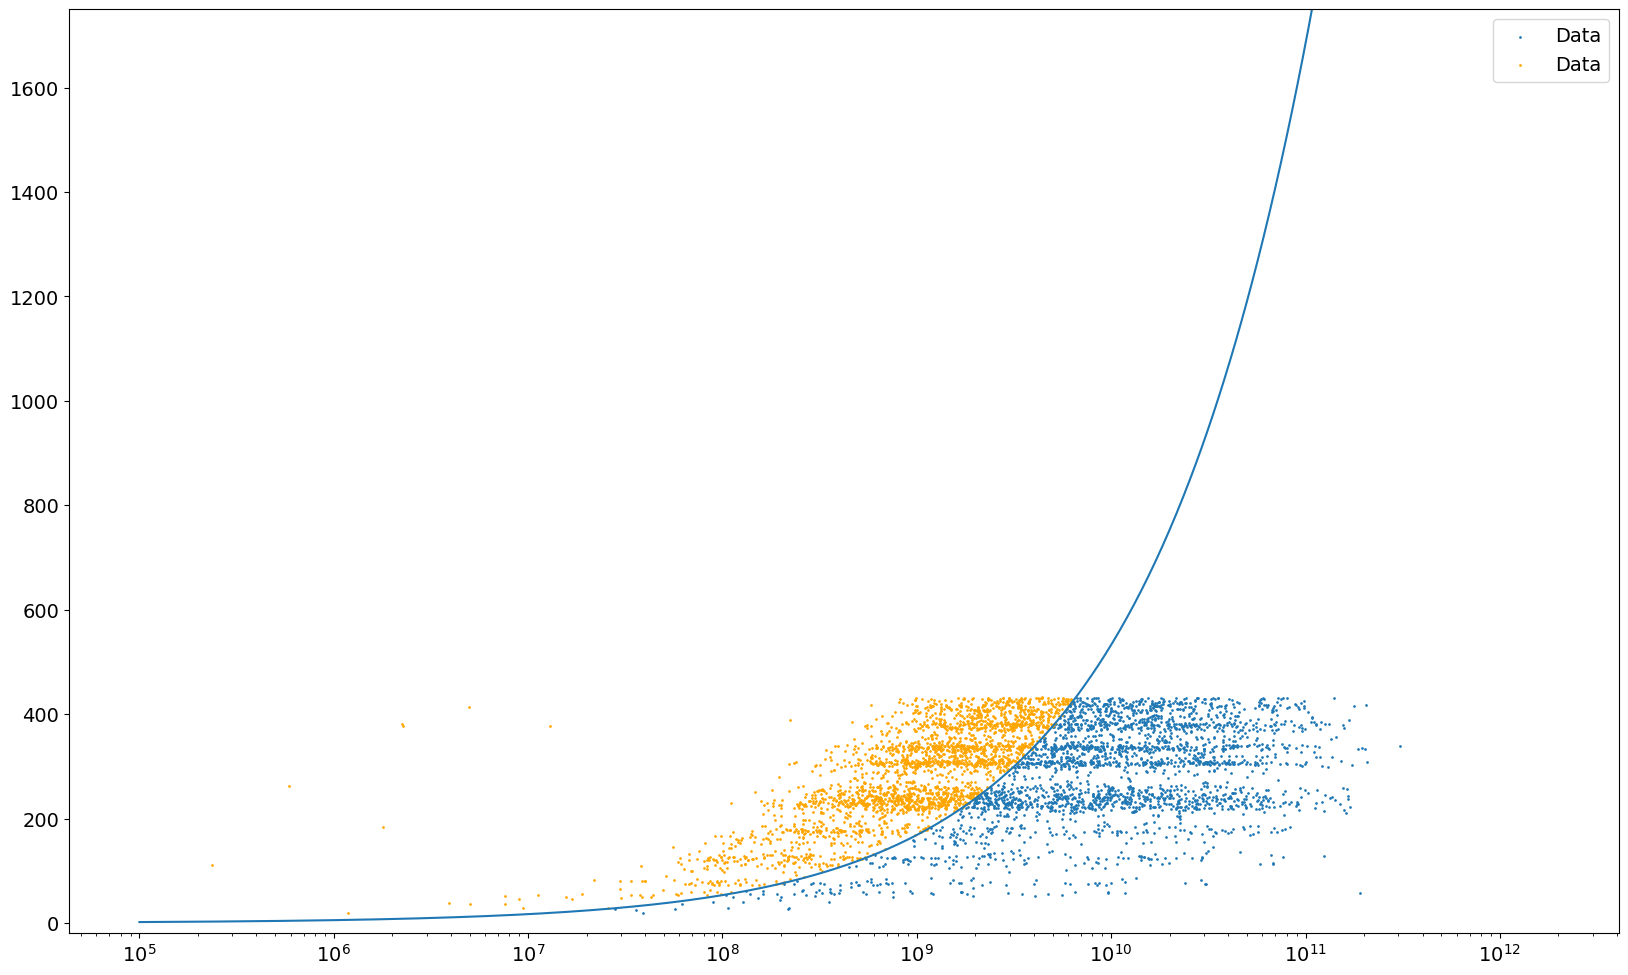

In [17]:
plt.plot(mass_for_richards_curve, richards_curve)
plt.scatter(merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['mstar'], merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['comoving_distance'], s=0.9, label='Data')
plt.scatter(merged_galaxy_df[merged_galaxy_df['within_richards_curve']== False]['mstar'], merged_galaxy_df[merged_galaxy_df['within_richards_curve']== False]['comoving_distance'], color= 'orange',  s=0.9, label='Data')
plt.xscale('log')
plt.ylim(-20, 1750)
plt.legend()

In [18]:
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[merged_galaxy_df['within_richards_curve']], region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

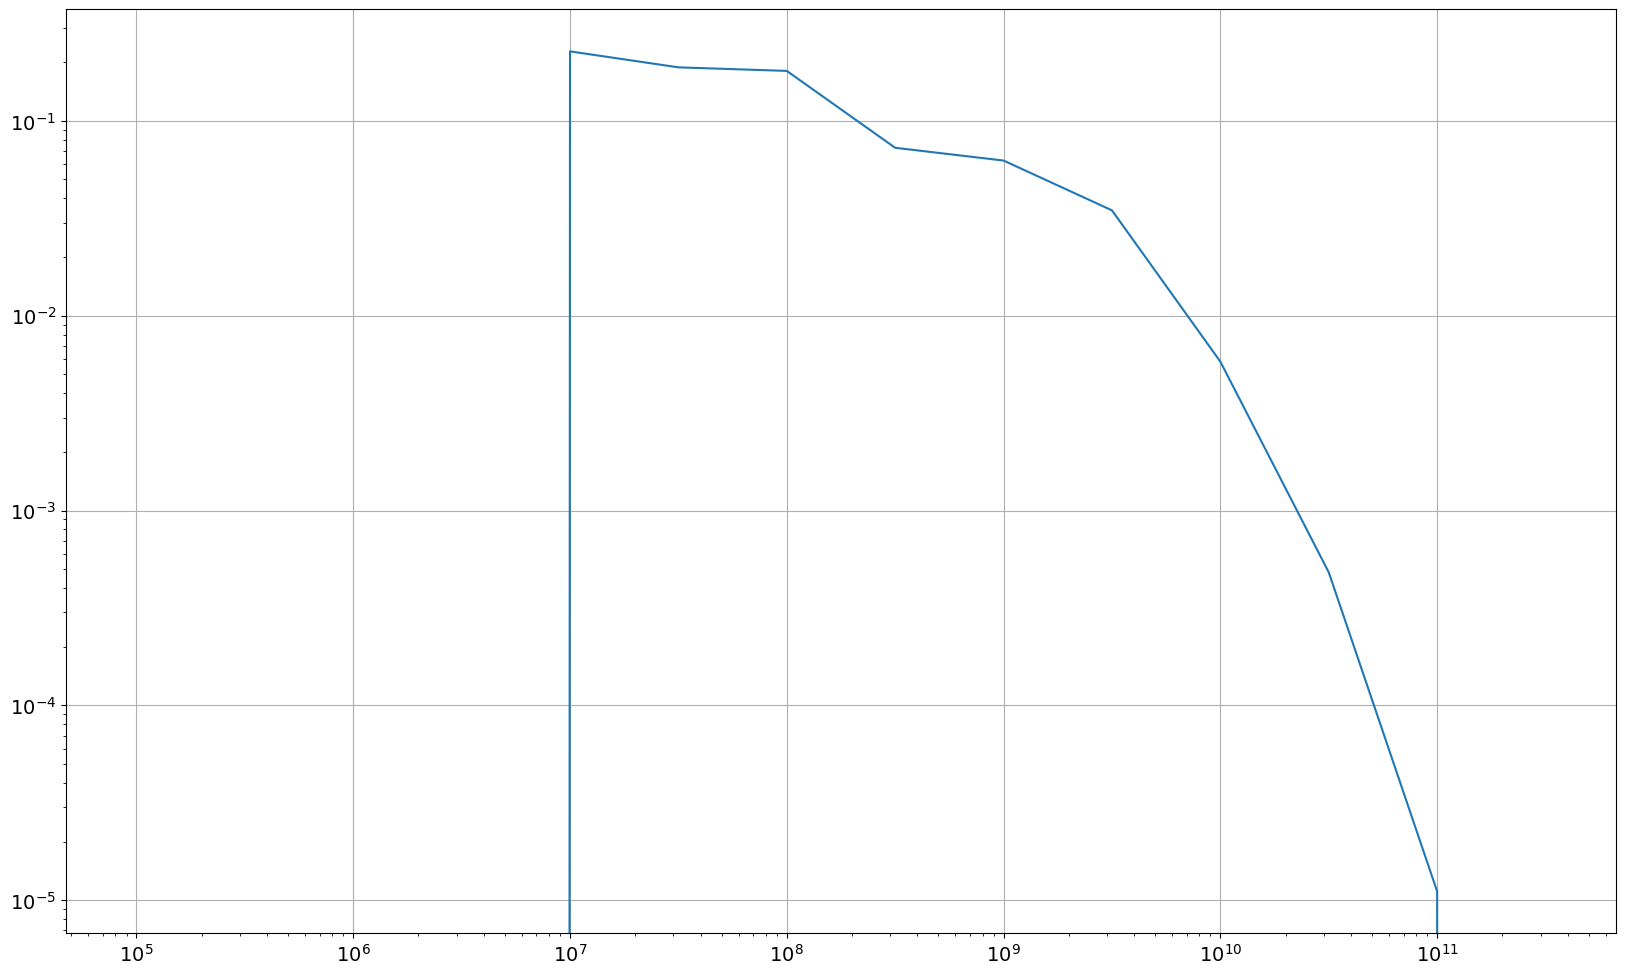

In [19]:
plt.plot(MASS_BINS[:-1], stellar_mass_function)
plt.xscale('log')
plt.yscale('log')
plt.grid()